In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets
from torchvision.transforms import ToTensor
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import json
import os
import shutil
import random
from PIL import Image

print('Using PyTorch version:', torch.__version__)
if torch.cuda.is_available():
    print('Using GPU, device name:', torch.cuda.get_device_name(0))
    device = torch.device('cuda')
else:
    print('No GPU found, using CPU instead.')
    device = torch.device('cpu')

Using PyTorch version: 2.3.1
No GPU found, using CPU instead.


In [2]:

# Définir une nouvelle transformation pour convertir les images en niveaux de gris
transform = transforms.Compose([
    transforms.Resize((112, 112)),  # Redimensionner les images à 112x112
    transforms.Grayscale(),  # Convertir les images en niveaux de gris
    transforms.ToTensor(),  # Convertir les images en tenseurs PyTorch
])


# Télécharger et charger le jeu de données Flowers102
dataset = datasets.Flowers102(root='./data', 
                              split='train', 
                              transform=transform, 
                              download=True)

# Séparer les données en ensemble d'entraînement et de test
# Calculer la taille de chaque sous-dataset
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# Diviser le dataset en ensemble d'entraînement et de test
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Créer des DataLoader pour les ensembles d'entraînement et de test
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Afficher les tailles des datasets pour vérification
print(f'Taille du dataset d\'entraînement: {len(train_dataset)}')
print(f'Taille du dataset de test: {len(test_dataset)}')

# Vérification des données
for (data, target) in train_loader:
    print('data:', data.size(), 'type:', data.type())
    print('target:', target.size(), 'type:', target.type())
    break

Taille du dataset d'entraînement: 816
Taille du dataset de test: 204
data: torch.Size([64, 1, 112, 112]) type: torch.FloatTensor
target: torch.Size([64]) type: torch.LongTensor


Autoencoder(
  (encoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=12544, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Linear(in_features=64, out_features=12, bias=True)
    (6): ReLU()
    (7): Linear(in_features=12, out_features=3, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=12, bias=True)
    (1): ReLU()
    (2): Linear(in_features=12, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=12544, bias=True)
    (7): Sigmoid()
  )
)
Training epoch: 1
Average loss: 0.066285
Training epoch: 2
Average loss: 0.057218
Training epoch: 3
Average loss: 0.050752
Training epoch: 4
Average loss: 0.049686
Training epoch: 5
Average loss: 0.049535
Training epoch: 6
Average loss: 0.049327
Training epoch: 7
Average loss: 0.04

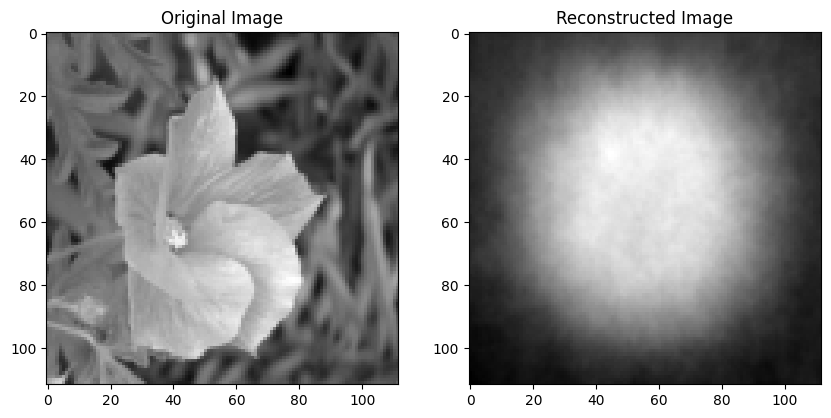

In [3]:

# Définition de l'autoencodeur
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(112 * 112, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3)
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 112 * 112),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

model = Autoencoder().to(device)
print(model)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Fonction de formation
def train(data_loader, model, criterion, optimizer):
    model.train()
    num_batches = len(data_loader)
    total_loss = 0

    for data, _ in data_loader:
        data = data.to(device)

        # Effectuer une passe avant
        output = model(data)

        # Calculer la perte
        loss = criterion(output, data.view(-1, 112 * 112))
        total_loss += loss.item()

        # Rétropropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    train_loss = total_loss / num_batches
    print(f"Average loss: {train_loss:.6f}")

# Entraînement de l'autoencodeur
epochs = 10
for epoch in range(epochs):
    print(f"Training epoch: {epoch + 1}")
    train(train_loader, model, criterion, optimizer)

# Visualisation des résultats
def visualize(model, data_loader):
    model.eval()
    with torch.no_grad():
        for data, _ in data_loader:
            data = data.to(device)
            output = model(data)
            output = output.view(-1, 1, 112, 112).cpu().numpy()
            break

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(data[0].cpu().numpy().squeeze(), cmap='gray')
    axes[0].set_title('Original Image')
    axes[1].imshow(output[0].squeeze(), cmap='gray')
    axes[1].set_title('Reconstructed Image')
    plt.show()

# Visualiser les résultats sur le jeu de test
visualize(model, test_loader)